# Does Oil Well Production Decrease with Age?

In this notebook, we explore the relationship between the age of an oil well and its output.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import zipfile
import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Opens zip file and creates data directory
# If files get large, will need to check to see if exists, and only replace new ones (or updates)
#zip_ref = zipfile.ZipFile('./data.zip', 'r')
#zip_ref.extractall('./')
#zip_ref.close()

In [3]:
# set some plot defaults
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

In [4]:
# function to calculate the number of months between a data and an array of dates
def months_since(dateto, datesfrom):
    m = [(dateto.year - d.year) * 12 + (dateto.month - d.month) for d in datesfrom]
    return np.array(m)

In [5]:
# read up the well data:
WellData_Raw = pd.read_csv("./data/welldata/WellData.csv",low_memory=False)

# get rid of the dup API nummber records by taking first in group
DimWell = WellData_Raw.groupby('API_num').first()

# ditch the wells for which there's no longitude or latitude:
DimWell.dropna(axis=0, how='any', subset=['long','lat'],inplace=True)

# fix up the completion date:
DimWell['complete_date'] = pd.to_datetime(DimWell['complete_date'])

#Age in months calculated from completion date:
DimWell['AgeMonths'] = months_since(datetime.datetime.today(),DimWell.complete_date)

In [6]:
def makeapinum(cnty, seq, sidetrack, st='05'):
    APInum = st + '-' + str(cnty).zfill(3) + '-' + str(seq).zfill(5) + '-' + \
                                            str(sidetrack).zfill(2)
    return APInum

In [7]:
# read up the production data
ProductionData_Raw = pd.read_csv("./data/welldata/Production.csv", low_memory=False)

# tack on an API code:
ProductionData_Raw['API_num'] = ProductionData_Raw.apply(lambda c:makeapinum(c.api_county_code, c.api_seq_num, c.sidetrack_num), axis=1)

# sum up the production data for each well:
FactProduction = ProductionData_Raw[['API_num','Prod_days','oil_prod']].groupby('API_num').sum()

# ditch the records for which there's no production data:
FactProduction.dropna(axis=0, how='any',inplace=True)

# join the Well data to the produciton data:
dimcols = ['long','lat', 'formation_code', 'complete_date','AgeMonths']
oil_df = FactProduction.merge(DimWell[dimcols], left_index=True, right_index=True)
oil_df['BblPerDay'] = oil_df.oil_prod/oil_df.Prod_days

# ditch the records before 1970
oil_df = oil_df.query('complete_date >= \'1/1/1970\'')

In [8]:
oil_df.head()

,Prod_days,oil_prod,long,lat,formation_code,complete_date,AgeMonths,BblPerDay
API_num,,,,,,,,
05-001-05542-00,34.0,37.0,-103.818583,39.981528,DSND,1985-03-06,396.0,1.088235
05-001-06007-00,244.0,172.0,-104.274980,39.874660,DSND,1981-08-22,439.0,0.704918
05-001-06072-00,206.0,58.0,-104.124690,39.944300,JSND,2004-09-30,162.0,0.281553
05-001-06121-00,351.0,602.0,-104.581070,39.857200,JSND,2012-04-25,71.0,1.715100
05-001-06137-00,328.0,259.0,-104.120310,39.897676,JSND,1988-09-15,354.0,0.789634


In [9]:
print('number of oil wells: %d, wells missing complete dates: %d' % (len(oil_df),oil_df.complete_date.isnull().sum()))

number of oil wells: 30060, wells missing complete dates: 0


## Age and Output Distribution

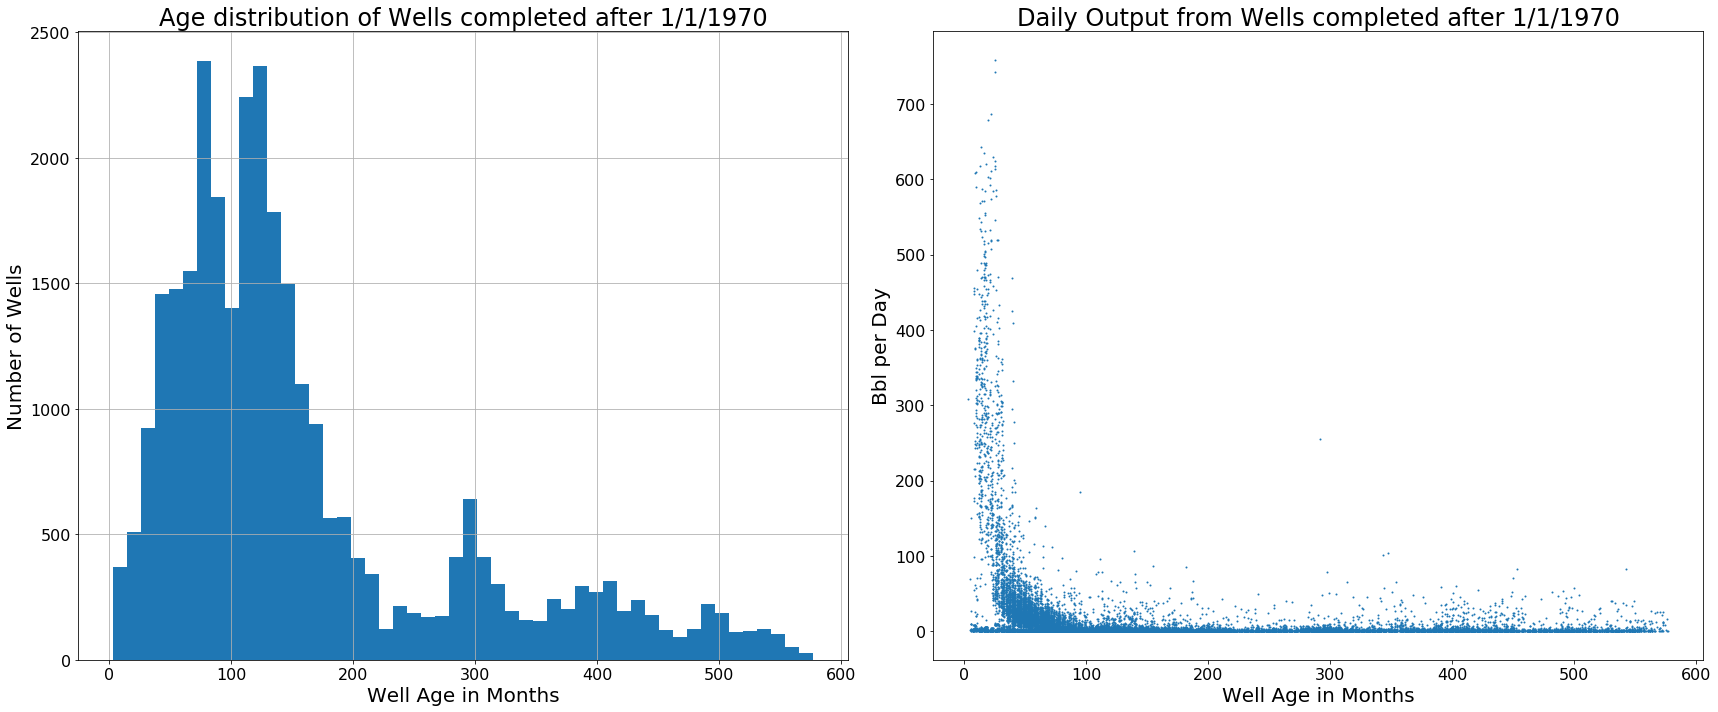

In [10]:
f = plt.figure(figsize=(24,10))
ax = plt.subplot(1,2,1)

oil_df.hist('AgeMonths',bins=50, ax=ax)
plt.title('Age distribution of Wells completed after 1/1/1970')
plt.ylabel('Number of Wells')
plt.xlabel('Well Age in Months')

ax = plt.subplot(1,2,2)
plt.scatter(oil_df.AgeMonths, oil_df.BblPerDay, s=1)
plt.title('Daily Output from Wells completed after 1/1/1970')
plt.ylabel('Bbl per Day')
plt.xlabel('Well Age in Months')
plt.tight_layout()

### Median Output

In [11]:
# calculate median value for each age
prod_med = oil_df.groupby('AgeMonths').median().BblPerDay
prod_med.head()

AgeMonths
3.0    307.737705
5.0     35.774194
6.0      2.555556
7.0      1.835443
8.0      2.647541
Name: BblPerDay, dtype: float64

In [12]:
#first two points look anomalous, so zero them out!!
prod_med.iloc[0:2] = 0
prod_med.head()

AgeMonths
3.0    0.000000
5.0    0.000000
6.0    2.555556
7.0    1.835443
8.0    2.647541
Name: BblPerDay, dtype: float64

In [13]:
# smooth the medians by fitting a spline
from scipy.interpolate import spline
xnew = np.linspace(prod_med.min(),prod_med.max(),200) #represents number of points to make between T.min and T.max
prod_med_smooth = spline(prod_med.index,prod_med.values,xnew)

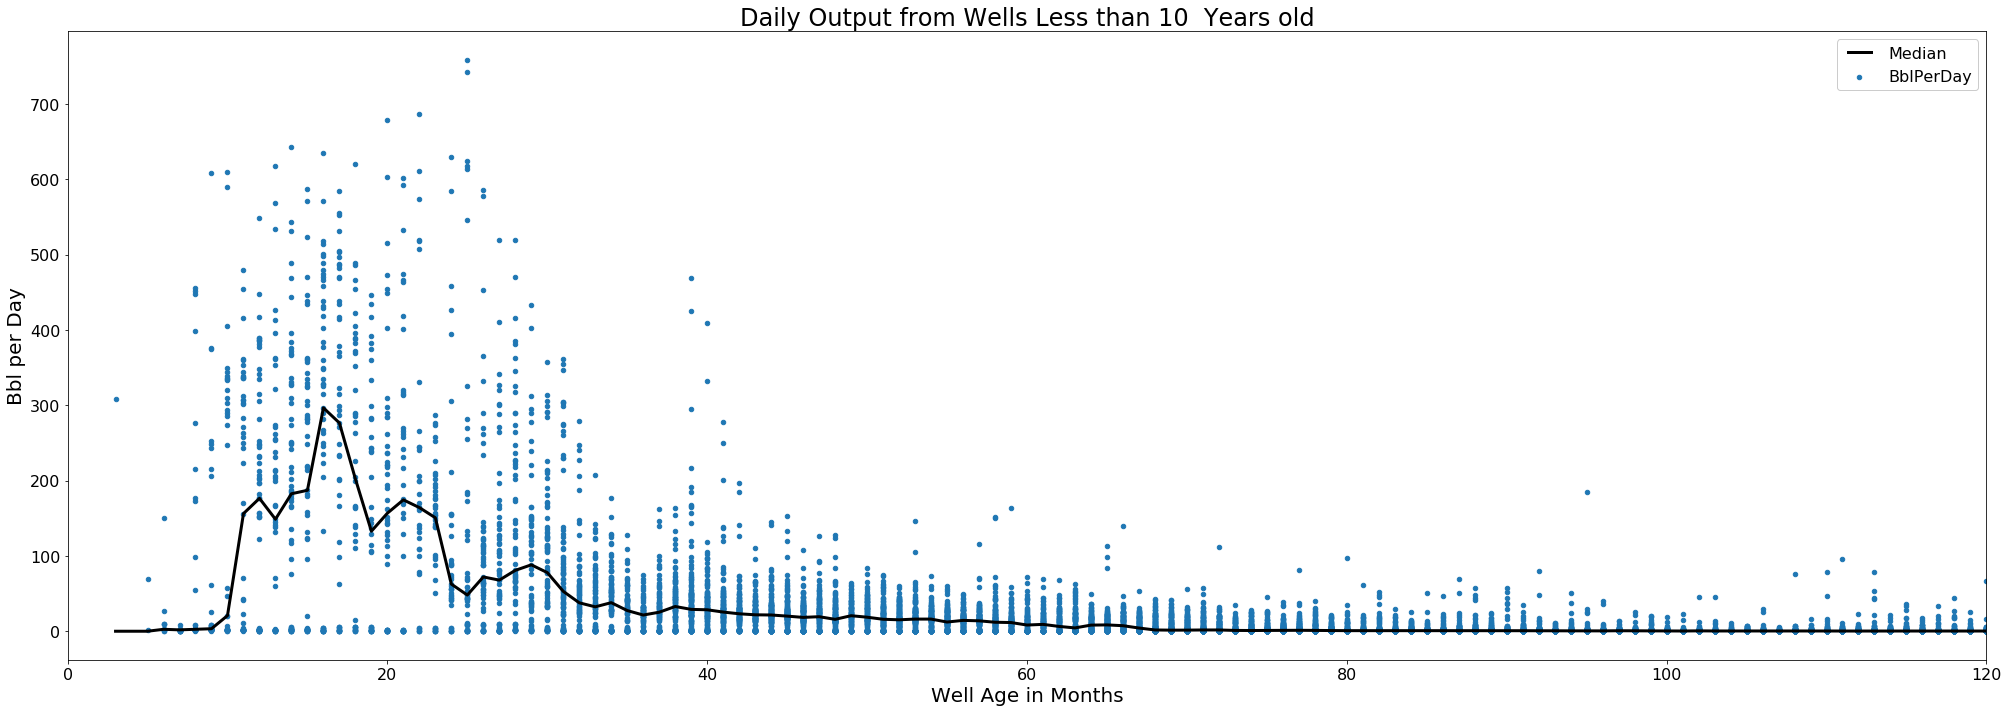

In [14]:
f = plt.figure(figsize=(28,10))
ax = plt.subplot()
ax.set_xlim(0,120)
plt.scatter(oil_df.AgeMonths, oil_df.BblPerDay, s=20)
plt.title('Daily Output from Wells Less than 10  Years old')
plt.ylabel('Bbl per Day')
plt.xlabel('Well Age in Months')
plt.plot(prod_med.index, prod_med.values,color='black',label='Median')
plt.legend(numpoints=2,fontsize=16,markerscale=1, facecolor="white",framealpha=1)
plt.tight_layout()

### Questions

1. What's going on with the wells with zero output that are less than 4 years old?
2. Can we look longitudinally (look at the history for one well (by month) to see if it shows the same pattern as the one above?
3. How does seasonallity affect this picture?
    + this is 2017 data - so wells <= 6 months old would have been completed in Sept, Oct Nov and Dec of 2017
4. should look at how many days these older wells were operating

## Productivity by Formation_code

+ make the same plot above only color code wells by formation code
+ how many formations?
+ what's age distribution in each formation?

In [15]:
len(oil_df.formation_code.unique())

162

### Top 10 producing formations

In [16]:
oil_df.head()

,Prod_days,oil_prod,long,lat,formation_code,complete_date,AgeMonths,BblPerDay
API_num,,,,,,,,
05-001-05542-00,34.0,37.0,-103.818583,39.981528,DSND,1985-03-06,396.0,1.088235
05-001-06007-00,244.0,172.0,-104.274980,39.874660,DSND,1981-08-22,439.0,0.704918
05-001-06072-00,206.0,58.0,-104.124690,39.944300,JSND,2004-09-30,162.0,0.281553
05-001-06121-00,351.0,602.0,-104.581070,39.857200,JSND,2012-04-25,71.0,1.715100
05-001-06137-00,328.0,259.0,-104.120310,39.897676,JSND,1988-09-15,354.0,0.789634


In [48]:
#df.groupby('A').agg({'B': ['min', 'max'], 'C': 'sum'})
prod_by_formation = oil_df.reset_index().groupby('formation_code').agg(\
    {'Prod_days':'sum','oil_prod':'sum',  'AgeMonths':'median', 'API_num':'size'})\
        .rename(columns={'API_num':'NumWells', 'AgeMonths':'MedianAge'})\
        .sort_values('oil_prod', ascending=False)
prod_by_formation['BblPerDay'] = prod_by_formation.oil_prod/prod_by_formation.Prod_days
prod_by_formation['PctProd'] = 100.0*prod_by_formation.oil_prod/prod_by_formation.oil_prod.sum()
prod_by_formation['CumPctProd'] = prod_by_formation.PctProd.cumsum()
prod_by_formation.head(10)

,Prod_days,oil_prod,MedianAge,NumWells,BblPerDay,PctProd,CumPctProd
formation_code,,,,,,,
NBRR,971922.0,35314457.0,55.0,3195,36.334662,39.270632,39.270632
N-COM,275015.0,27335402.0,30.0,929,99.396040,30.397707,69.668339
CODL,1475486.0,9337347.0,139.0,6952,6.328320,10.383383,80.051722
CARL,38736.0,5531394.0,30.0,133,142.797243,6.151060,86.202782
CD-FH,41800.0,2780433.0,41.0,137,66.517536,3.091917,89.294699
WEBR,79291.0,2106481.0,422.0,266,26.566458,2.342464,91.637163
WFCM,1863977.0,684518.0,116.0,5565,0.367235,0.761203,92.398365
MRRW,49538.0,672801.0,355.0,153,13.581513,0.748173,93.146538
NB-CD,414370.0,647354.0,122.0,2120,1.562261,0.719875,93.866413


In [62]:
#get the formations in their descending order of production
n = 10
top_n = prod_by_formation['oil_prod'].sort_values(ascending=True).iloc[-1*n:].index
top_n

Index(['JSND  ', 'NB-CD ', 'MRRW  ', 'WFCM  ', 'WEBR  ', 'CD-FH ', 'CARL  ',
       'CODL  ', 'N-COM ', 'NBRR  '],
      dtype='object', name='formation_code')

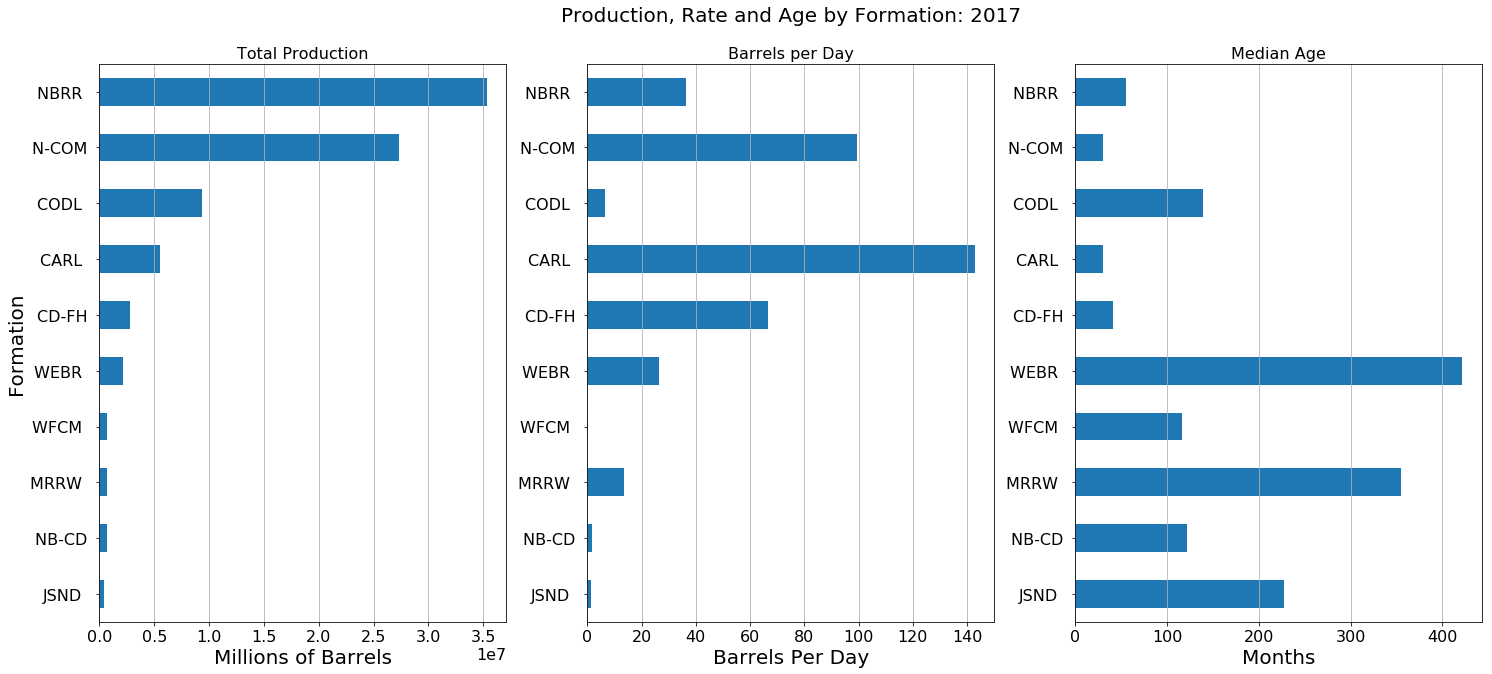

In [71]:
f = plt.figure(figsize=(24,10))
plt.suptitle('Production, Rate and Age by Formation: 2017',size=20)
ax = plt.subplot(1,3,1)
# df2.plot.barh(stacked=True);

prod_by_formation['oil_prod'].loc[top_n].plot.barh(ax=ax)
plt.title('Total Production',size=16)
plt.grid(axis='x')
plt.xlabel('Millions of Barrels')
plt.ylabel('Formation')

ax = plt.subplot(1,3,2)
prod_by_formation.loc[top_n].BblPerDay.plot.barh(ax=ax)
plt.title('Barrels per Day',size=16)
plt.grid(axis='x')
plt.xlabel('Barrels Per Day')
plt.ylabel('')

ax = plt.subplot(1,3,3)
prod_by_formation.loc[top_n].MedianAge.plot.barh(ax=ax)
plt.title('Median Age',size=16)
plt.grid(axis='x')
plt.xlabel('Months')
plt.ylabel('')
plt.subplots_adjust(left=0.1,  top=0.9)
#plt.tight_layout()


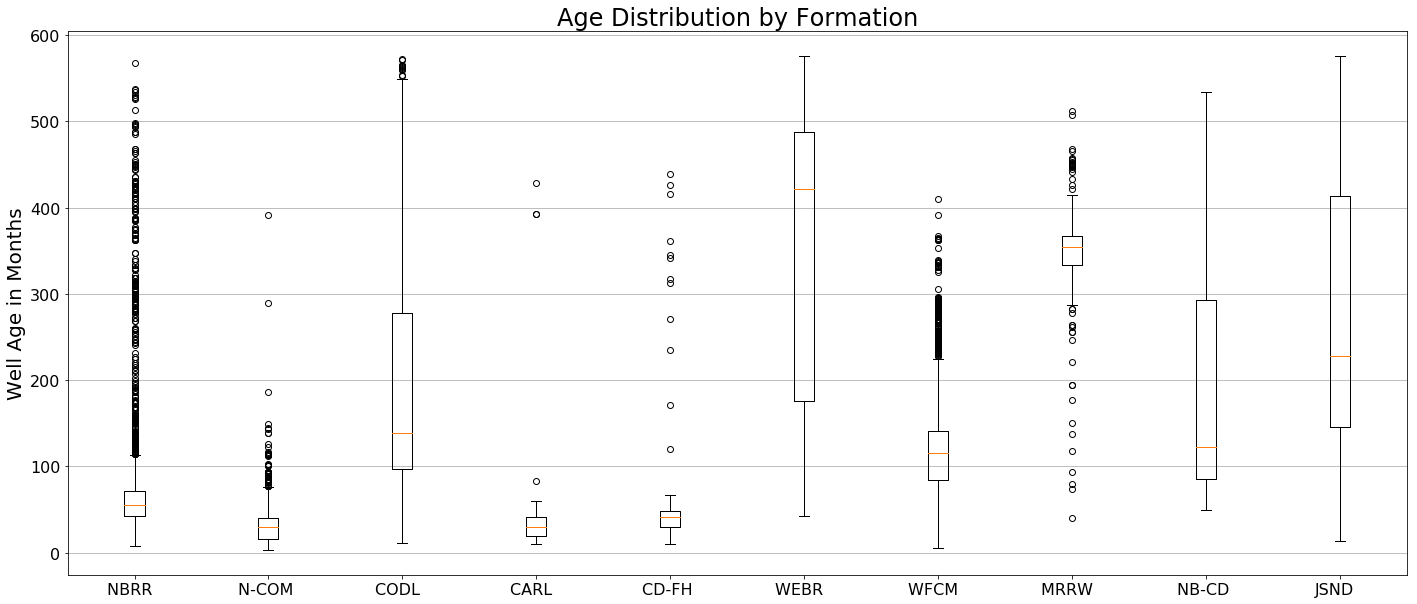

In [93]:
fig, ax = plt.subplots(figsize=(24,10))
for pos, form in enumerate(top_n[::-1]):
    ax.boxplot(oil_df.query('formation_code == @form').AgeMonths, positions=[pos])
ax.set_xticks(range(pos+1))
ax.set_xticklabels(top_n[::-1])
ax.set_xlim(xmin=-0.5)

plt.title('Age Distribution by Formation')
plt.ylabel('Well Age in Months')
plt.grid(axis='y')
plt.show()


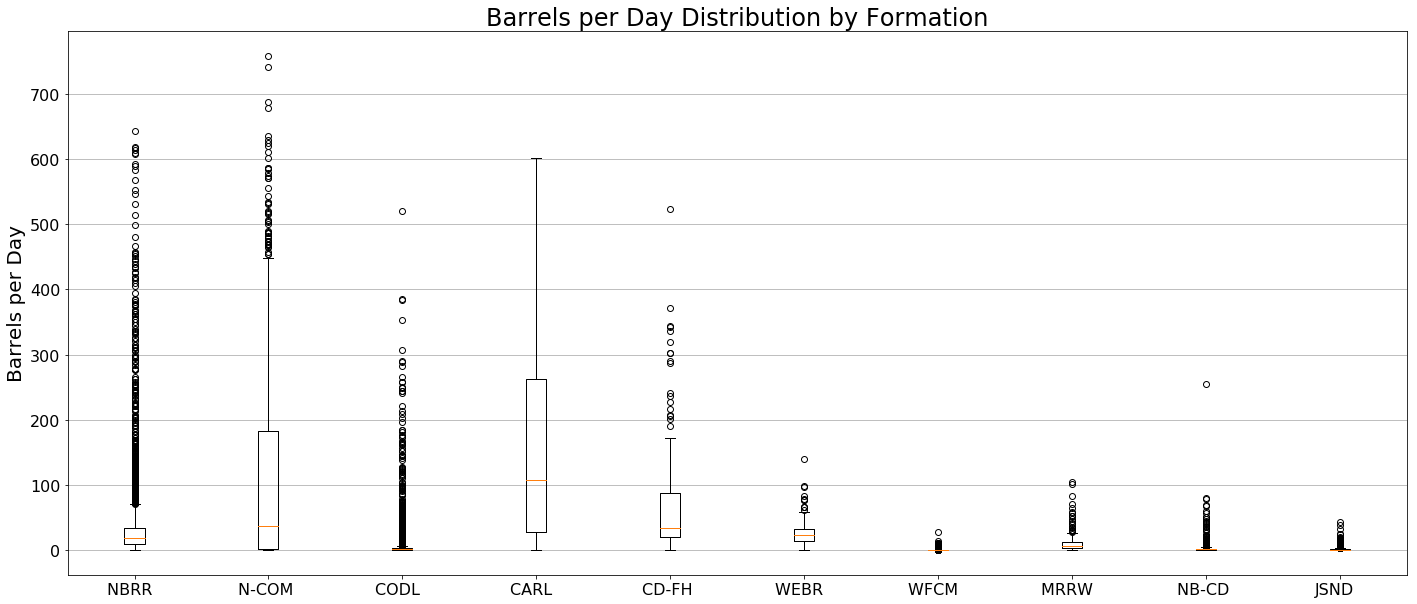

In [95]:
fig, ax = plt.subplots(figsize=(24,10))
for pos, form in enumerate(top_n[::-1]):
    ax.boxplot(oil_df.query('formation_code == @form').BblPerDay, positions=[pos])
ax.set_xticks(range(pos+1))
ax.set_xticklabels(top_n[::-1])
ax.set_xlim(xmin=-0.5)

plt.title('Barrels per Day Distribution by Formation')
plt.ylabel('Barrels per Day')
plt.grid(axis='y')
plt.show()